In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Import BigQuery 
from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


# Importing Data

In [3]:
# Construct a reference to the first dataset "covid19_nyt"
dataset_ref = client.dataset("covid19_nyt", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# List all the tables in the "covid19_nyt" dataset
tables = list(client.list_tables(dataset))

# Print names of all tables in the dataset
for table in tables:  
    print(table.table_id)

excess_deaths
mask_use_by_county
us_counties
us_states


In [4]:
# Construct a reference to the "us_counties" table
table_ref = dataset_ref.table("us_counties")

# API request - fetch the table
table = client.get_table(table_ref)


# Preview the first five rows of the "us_counties" table
client.list_rows(table, max_results=5).to_dataframe()

,date,county,state_name,county_fips_code,confirmed_cases,deaths
0,2020-06-22,Adair,Iowa,19001,12,0
1,2020-06-23,Adair,Iowa,19001,12,0
2,2020-06-24,Adair,Iowa,19001,13,0
3,2020-06-25,Adair,Iowa,19001,14,0
4,2020-06-26,Adair,Iowa,19001,14,0


In [5]:
# Construct a reference to the "mask_use_by_county" table
table_ref = dataset_ref.table("mask_use_by_county")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five rows of the "mask_use_by_county" table
client.list_rows(table, max_results=5).to_dataframe()

,county_fips_code,never,rarely,sometimes,frequently,always
0,15007,0.0,0.021,0.046,0.108,0.825
1,36011,0.0,0.033,0.072,0.162,0.732
2,48209,0.0,0.007,0.022,0.115,0.855
3,51740,0.0,0.019,0.122,0.225,0.634
4,17019,0.0,0.067,0.080,0.192,0.661


# Applying Queries

In [7]:
###### The Average Number of Covid19 Cases per County ######

query2 = """
                SELECT county, AVG(confirmed_cases) AS num_cases 
                FROM `bigquery-public-data.covid19_nyt.us_counties`
                GROUP BY county
                ORDER BY num_cases DESC
                """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query2, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
Covid19 = query_job.to_dataframe()

# Print the first ten rows of the DataFrame
Covid19.head(10)

,county,num_cases
0,New York City,169006.583333
1,Los Angeles,75541.374449
2,Miami-Dade,52191.324176
3,Maricopa,38670.643172
4,Westchester,27706.322751
5,Cook,26466.562500
6,Broward,23071.160428
7,Suffolk,22025.034483
8,Philadelphia,20317.939891
9,Riverside,17940.413978


In [25]:
###### The MAX Number of Covid19 Cases per County Which always Wears Masks ######

query2 = """  
             SELECT c.county, SUM(s.always) AS num_always ,MAX(c.confirmed_cases) AS num_confirmed_cases
             FROM `bigquery-public-data.covid19_nyt.mask_use_by_county` AS s, `bigquery-public-data.covid19_nyt.us_counties` AS c
             WHERE s.county_fips_code = c.county_fips_code 
             GROUP BY county
             ORDER BY num_confirmed_cases DESC
             
                """
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query2, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
Covid19 = query_job.to_dataframe()

# Print the first five rows of the DataFrame
Covid19.head(10)

,county,num_always,num_confirmed_cases
0,Los Angeles,178.422,249241
1,Miami-Dade,137.592,162025
2,Maricopa,166.618,136040
3,Cook,281.221,132079
4,Harris,232.038,112039
5,Dallas,443.405,77326
6,Broward,147.917,73556
7,Clark,927.236,61543
8,Riverside,149.358,54572
9,Orange,982.681,51016


#  Discover AND Remove outliers

           county  num_always  num_confirmed_cases
0     Los Angeles     178.422               249241
1      Miami-Dade     137.592               162025
2        Maricopa     166.618               136040
3            Cook     281.221               132079
4          Harris     232.038               112039
...           ...         ...                  ...
1832    Hitchcock      39.732                    2
1833         Loup       4.134                    2
1834       Alpine      99.756                    2
1835      Harding      97.388                    2
1836       Arthur      12.104                    1

[1837 rows x 3 columns]


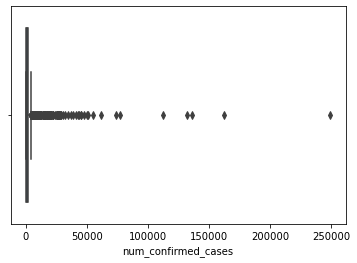

In [26]:
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import numpy as np
import seaborn as sns

sns.boxplot(x=Covid19['num_confirmed_cases'])

#coIn.plot.bar(x="num_always", y="num_confirmed_cases")
#plt.show()
#coIn.plot( y=["num_always", "num_confirmed_cases"])
print(Covid19)
#boston_df_o = coIn[(z < 3).all(axis=1)]

In [27]:
#separate #Covid19  into parts with numerical and categorical features:
num_Covid19 = Covid19.select_dtypes(include=["number"])
cat_Covid19 = Covid19.select_dtypes(exclude=["number"])

#remove outliers by use z-score
idx = np.all(stats.zscore(num_Covid19) < 3, axis=1)

# add the two parts together:
import pandas as pd  
Covid19_cleaned = pd.concat([num_Covid19.loc[idx], cat_Covid19.loc[idx]], axis=1)

print(Covid19_cleaned)

      num_always  num_confirmed_cases     county
21       117.568                30202       Kern
22       204.460                28833    Hidalgo
23       689.108                28478     Shelby
24       216.117                27802      Duval
25       530.541                27769  Middlesex
...          ...                  ...        ...
1832      39.732                    2  Hitchcock
1833       4.134                    2       Loup
1834      99.756                    2     Alpine
1835      97.388                    2    Harding
1836      12.104                    1     Arthur

[1779 rows x 3 columns]


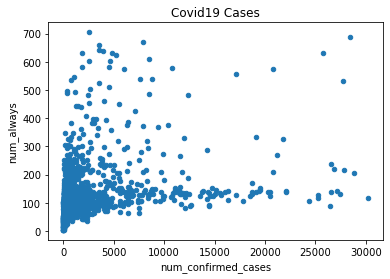

In [28]:
# Relation After Applying Normalization
#normalized_df = (coIn-coIn.mean())/coIn.std()
#normalized_df.plot( y=["num_rarely", "num_confirmed_cases"])
Covid19_cleaned.plot.scatter(x='num_confirmed_cases', y='num_always', title='Covid19 Cases')
plt.show()

# MODELE 2

In [21]:
###### The MIN Number of Covid19 Cases per County Which always Wears Masks ######

query3 = """  
             SELECT c.county, SUM(s.always) AS num_always ,MIN(c.confirmed_cases) AS num_confirmed_cases
             FROM `bigquery-public-data.covid19_nyt.mask_use_by_county` AS s, `bigquery-public-data.covid19_nyt.us_counties` AS c
             WHERE s.county_fips_code = c.county_fips_code 
             GROUP BY county
             ORDER BY num_confirmed_cases DESC
             
                """
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query3, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
Covid19_2 = query_job.to_dataframe()

# Print the first five rows of the DataFrame
Covid19_2.head(10)

#import matplotlib.pyplot as plt

#coIn2.plot( y=["num_always", "num_confirmed_cases"])
#coIn2.plot.scatter(x='num_confirmed_cases', y='num_always', title='Covid19 Cases')
#plt.show()

,county,num_always,num_confirmed_cases
0,Providence,126.672,37
1,Pitkin,115.206,9
2,Westchester,150.822,9
3,Newport,136.920,8
4,Dougherty,129.228,6
5,McLennan,126.175,5
6,Creek,69.720,5
7,Stonewall,23.797,4
8,Travis,143.100,4
9,Hernando,102.486,4


# * Discover AND Remove outliers

In [23]:
#separate #Covid19  into parts with numerical and categorical features:
num_Covid19_2 = Covid19_2.select_dtypes(include=["number"])
cat_Covid19_2 = Covid19_2.select_dtypes(exclude=["number"])

#remove outliers by use z-score
idx = np.all(stats.zscore(num_Covid19_2) < 3, axis=1)

# add the two parts together:
import pandas as pd  
Covid19_2_cleaned = pd.concat([num_Covid19_2.loc[idx], cat_Covid19_2.loc[idx]], axis=1)

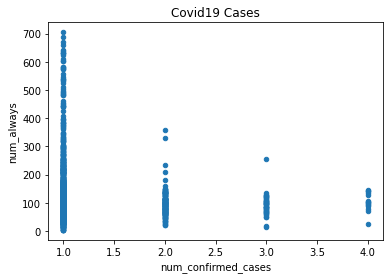

In [24]:
Covid19_2_cleaned.plot.scatter(x='num_confirmed_cases', y='num_always', title='Covid19 Cases')
plt.show()

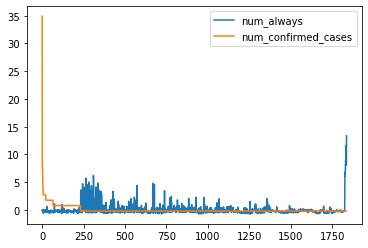

In [14]:
# Relation After Applying Normalization
#normalized_df = (coIn2-coIn2.mean())/coIn2.std()
#normalized_df.plot( y=["num_always", "num_confirmed_cases"])
#plt.show()